In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

from torch.utils.data import DataLoader
from torch.optim import Adam

from soundgen.datasets import TinyPianoDataset
from soundgen.transformations.preprocess import PreprocessingModule
from soundgen.models import VAE
from soundgen.models.vae import VAELoss
from soundgen.scripts.train import VAETrainer
from soundgen.configs import TrainConfig, VAEConfig


In [3]:
top_folder = Path().resolve().parent
print(top_folder)

/Users/borispodolnyi/Documents/coding_projects/soundgen


In [18]:
preprocessing = PreprocessingModule(n_fft=256, n_mels=32)
dataset = TinyPianoDataset(top_folder / "data/tiny_piano", transform=preprocessing)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [19]:
X, sr, lbl = dataset[0]

In [20]:
X.shape

torch.Size([1, 32, 173])

In [21]:
# Create training configuration
train_config = TrainConfig(
    num_epochs=100,
    learning_rate=0.001,
    batch_size=32
)

In [35]:
vae_config = VAEConfig.from_json(top_folder / "configs/vae_1d.json")

In [36]:
vae_config.input_shape = list(X.shape)

In [37]:
vae_config

VAEConfig(
    input_shape=[1, 32, 173],
    conv_filters_number=[128, 64, 32, 32, 16],
    conv_kernel_size=[3, 3, 3, 3, 3],
    conv_strides=[2, 2, 2, 2, 2],
    latent_space_dim=128,
    padding=1,
    shape_before_bottleneck=(16, 1, 6),
    kl_weight=0.0005
)

In [38]:
vae_config_dict = vae_config.to_dict().copy()
_ = vae_config_dict.pop('kl_weight')

vae_model = VAE(**vae_config_dict)

In [39]:
vae_config.kl_weight

0.0005

In [40]:
vae_loss = VAELoss(mse_loss_weight=1/vae_config.kl_weight, warmup_epochs=3)

In [41]:
optimizer = Adam(vae_model.parameters(), lr=train_config.learning_rate)

In [42]:
# Initialize trainer
trainer = VAETrainer(
    optimizer=optimizer,
    loss_fn=vae_loss,
    model=vae_model,
    train_loader=train_loader,
    device="mps"
)

In [43]:
# Train the model
trainer.train(num_epochs=train_config.num_epochs)

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]/Users/borispodolnyi/Documents/coding_projects/soundgen/src/soundgen/models/vae.py:260: UserWarning: Using a target size (torch.Size([19, 1, 32, 173])) that is different to the input size (torch.Size([19, 1, 32, 192])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  reconstruction_loss = nn.functional.mse_loss(X, X_reconstructed, reduction="mean")
Epoch:   0%|          | 0/100 [00:01<?, ?it/s]


RuntimeError: The size of tensor a (192) must match the size of tensor b (173) at non-singleton dimension 3

In [18]:
save_folder = top_folder / "models"
save_folder.mkdir(exist_ok=True)

In [19]:
trainer.model.save(weights_path=save_folder / "vae_1d.pth", params_path=save_folder / "vae_1d.json")

In [ ]:
from soundgen.transformations.postprocess import MelToWaveformTransform

In [20]:
predictor = VAE.load(
    weights_path=save_folder / "vae_1d.pth",
    params_path=save_folder / "vae_1d.json",
)

In [52]:
X = dataset[1][0].unsqueeze(0)
# X_reconstructed = predictor(X)
X_reconstructed = X

In [53]:
X_reconstructed.shape

torch.Size([1, 1, 64, 64])

In [54]:
reconstruct_transform = MelToWaveformTransform(sample_rate=22050, n_fft=1024, n_mels=64)

In [55]:
X_wav = reconstruct_transform(X_reconstructed.squeeze(0).detach())

In [60]:
dataset.return_raw = True
X_raw = dataset[1]
dataset.return_raw = False

In [58]:
from IPython.display import Audio, display

display(Audio(X_wav / 10000, rate=sr))

In [59]:
display(Audio(X_raw / 10000, rate=sr))

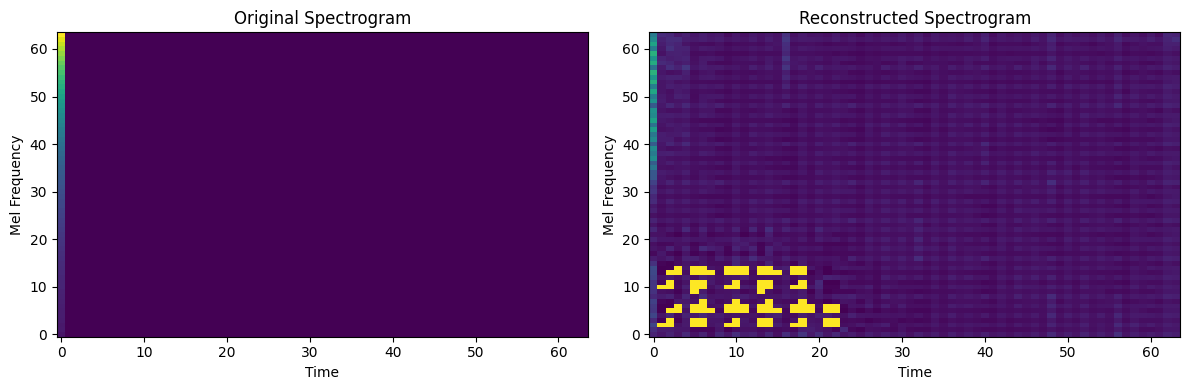

In [51]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot original spectrogram
axes[0].imshow(X.squeeze().detach().numpy(), aspect='auto', origin='lower', cmap='viridis')
axes[0].set_title('Original Spectrogram')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Mel Frequency')

# Plot reconstructed spectrogram
axes[1].imshow(X_reconstructed.squeeze().detach().numpy(), aspect='auto', origin='lower', cmap='viridis')
axes[1].set_title('Reconstructed Spectrogram')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Mel Frequency')

plt.tight_layout()
plt.show()